#Still in progress

In [7]:
import pandas as pd
import numpy as np
import string
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
import nltk
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, roc_auc_score
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
import seaborn as sns

## Class for Sentiment ML

In [8]:
class SentimentML_RandForest:
    
    def __init__(self):
        
        self.pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())])
        
        self.model = None
        nltk.download('stopwords')
        nltk.download('wordnet')
    
    
    def __contains_only_numb(self, word):
        numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        for a in word:
            if a not in numbers:
                return False
        return True

    def __remove_numb(self, word):
        numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        for a in word:
            if a in numbers:
                word = word.replace(a, '')
        return word

    def __clear_word(self, word):
        arr_en = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                  'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

        arr_EN = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                  'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

        numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

        for a in word:
            if (a not in arr_en) and (a not in arr_EN) and (a not in numbers):
                word = word.replace(a, '')
        return word
    
    def _preprocessing(self, df_data):
        
        df = df_data.copy()
        
        # replace " '" with "'"

        df['news'] = df['news'].apply(lambda x: x.lower().strip().replace(" '", "'"))
        df.head()

        # lower and remove punctuation

        remove_punctuation = string.punctuation

        df['news'] = df['news'].apply(lambda x: x.lower().strip().translate(str.maketrans('', '', remove_punctuation)))

        # spliting

        df['news'] = df['news'].apply(lambda x: x.split())

        # remove trash from words

        df['news'] = df['news'].apply(lambda x: [self.__clear_word(word) for word in x])

        # replace numbers to 'number'

        df['news'] = df['news'].apply(lambda x: [('number' if self.__contains_only_numb(word) else word) for word in x])

        # remove numbers from words

        df['news'] = df['news'].apply(lambda x: [self.__remove_numb(word) for word in x])

        # remove stopwords

        stopwords = nltk.corpus.stopwords.words('english')
        df['news'] = df['news'].apply(lambda x: [word for word in x if word not in stopwords])

        # remove 'nannan'

        df['news'] = df['news'].apply(lambda x: [word for word in x if word != 'nannan'])

        # lemmatizing

        lemmatizer = WordNetLemmatizer()
        df['news'] = df['news'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

        # replace urls with 'url'

        df['news'] = df['news'].apply(lambda x: [('url' if ('http' in word) else word) for word in x])

        #remove frequent words

        cnt = Counter()
        for news in df["news"]:
            for word in news:
                cnt[word] += 1

        FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
        df["news"] = df["news"].apply(lambda x: [word for word in x if word not in FREQWORDS])

        df.dropna(inplace = True)
        
        # join words
        
        df['news'] = df['news'].apply(lambda x: " ".join(x))

        return df
    
    def train(self, df_train_data):
        
        """
        You should firstly map targets to 0 and 1
        and have column 'news' in your dataframe
        """
        
        self._preprocessing(df_train_data)
        
        X_train = df_train_data['news']
        y_train = df_train_data['target']
        
        self.model = self.pipe.fit(X_train, y_train)
        
    def predict(self, df_data):
        
        """
        You should have column 'news' in your dataframe
        """
        
        self._preprocessing(df_data)
        X = df_data['news']
        
        return self.model.predict(X)
    
    def predict_proba(self, df_data):
        
        """
        You should have column 'news' in your dataframe
        """
        
        self._preprocessing(df_data)
        X = df_data['news']
        
        return self.model.predict_proba(X)


## Read data

In [9]:
# read data
df1 = pd.read_excel('all-data1.xlsx')
df1.columns = ['emotion', 'text_1', 'text_2', 'text_3']
df1['news'] = df1['text_1'].astype(str) + df1['text_2'].astype(str) + df1['text_3'].astype(str)
df1.drop(['text_1', 'text_2', 'text_3'], axis = 1, inplace = True)
df1 = df1[df1['emotion'] != 'neutral']
df1['target'] = df1['emotion']
df1.drop('emotion', axis = 1, inplace = True)

df1.head()

,news,target
1,The international electronic industry company ...,negative
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive
5,"For the last quarter of 2010 , Componenta 's n...",positive


In [10]:
# mapping of target
df1['target'] = df1['target'].map({'negative' : 0, 'positive' : 1})

df1.head()

,news,target
1,The international electronic industry company ...,0
2,With the new production plant the company woul...,1
3,According to the company 's updated strategy f...,1
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
5,"For the last quarter of 2010 , Componenta 's n...",1


In [11]:
# read more data
df2 = pd.read_csv('stock_data.csv')
df2.columns = ['news', 'target']

df2['target'] = pd.get_dummies(df2['target'].astype(str), drop_first= True)
df2.head()

,news,target
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [12]:
# concat all data
df = pd.concat([df1, df2])
print(df.shape)
df.head()

(7758, 2)


,news,target
1,The international electronic industry company ...,0
2,With the new production plant the company woul...,1
3,According to the company 's updated strategy f...,1
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
5,"For the last quarter of 2010 , Componenta 's n...",1


## Train model and predict

In [13]:
# read data to predict

df_to_pred = pd.read_excel('AmazonNews.xlsx')
df_to_pred['news'] = df_to_pred['Заголовок новости']
remove_columns = ['Дата', 'Время', 'Заголовок новости', 'Unnamed: 3', 'Unnamed: 4',
                 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Matt Day (author)']

df_to_pred.drop(axis = 1, columns = remove_columns, inplace = True)
df_to_pred['target'] = np.nan
df_to_pred.head(31)

,news,target
0,Amazon Plans to Offer Telehealth Services to O...,NaN
1,"Who Helps Pay Amazon, Walmart and McDonald's W...",NaN
2,Amazon’s New Grocery Store Chain Is More Tradi...,NaN
3,"Why Amazon, Google, and Microsoft Are Designin...",NaN
4,Apple and Amazon Buy Into Push to Make India M...,NaN
5,Amazon Sued for Alleged Hiring Bias,NaN
6,Bezos-Backed Vegan Milk Startup in Chile Eyes ...,NaN
7,Amazon Spends $131 Million for Stake in Cargo ...,NaN
8,"Amazon Union Vote Hit By Conspiracy Theories, ...",NaN
9,"Amazon Opening Cashierless Store in London, Fi...",NaN


#Bad Classifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


                                                 news  target  prob_of_1
0   Amazon Plans to Offer Telehealth Services to O...       1       0.70
1   Who Helps Pay Amazon, Walmart and McDonald's W...       1       0.65
2   Amazon’s New Grocery Store Chain Is More Tradi...       1       0.89
3   Why Amazon, Google, and Microsoft Are Designin...       1       0.63
4   Apple and Amazon Buy Into Push to Make India M...       1       0.70
5                 Amazon Sued for Alleged Hiring Bias       1       0.98
6   Bezos-Backed Vegan Milk Startup in Chile Eyes ...       1       0.89
7   Amazon Spends $131 Million for Stake in Cargo ...       1       0.87
8   Amazon Union Vote Hit By Conspiracy Theories, ...       1       0.73
9   Amazon Opening Cashierless Store in London, Fi...       1       0.75
10  Amazon Go Rival Bets Pandemic Made Case for Ca...       1       0.64
11  Amazon's (AMZN) Andy Jassy Will Take Over Jeff...       1       0.70
12  Amazon Bid to Delay Union Vote Rejected; Ballo.

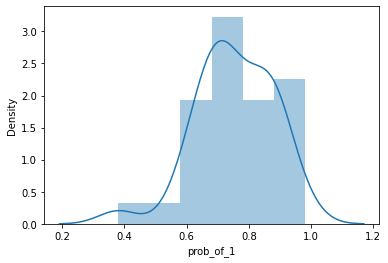

In [14]:
df_train = df

SentimentML = SentimentML_RandForest()
SentimentML.train(df_train)
df_to_pred['target'] = SentimentML.predict(df_to_pred)
df_to_pred['prob_of_1'] = SentimentML.predict_proba(df_to_pred)[:,1]

sns.distplot(df_to_pred['prob_of_1'])

df_to_pred.to_csv("Amazon_pred.csv")

print(df_to_pred)